# Reading the ROOT files

In [59]:
# %matplotlib notebookimport uproot
import numpy as np
import pandas as pd
import awkward as ak
from scipy.stats import norm
import scipy.interpolate as interpolate
from scipy.ndimage import median as med

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, InputLayer
from tensorflow.keras.layers import Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import sequence
import keras_tuner as kt

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import callbacks, regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelBinarizer

In [2]:
from tensorflow.keras import callbacks

In [9]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Embedding, Input, InputLayer, Concatenate, Flatten
from tensorflow.keras.preprocessing import sequence
# from keras.preprocessing import to_categorical

In [5]:
import uproot
import numpy as np
import pandas as pd

In [6]:
import matplotlib.pyplot as plt
import awkward as ak
from mpl_toolkits.mplot3d import axes3d 
from matplotlib.colors import LogNorm
import IPython
from sklearn import metrics

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [8]:
from scipy.stats import norm
import scipy.interpolate as interpolate
from scipy.ndimage import median as med

In [10]:
pmtpos = np.loadtxt('pmtpositions.csv', delimiter=',') + 1. 
pmtpos = np.vstack((np.array([0, 0, 0]), pmtpos))

In [27]:
ibd = ak.from_json('data/ibd.json')
fastn = ak.from_json('data/fastn.json')

In [29]:
# Time-sort all the data arrays for recurrent/sequential purposes. 
for j, data in enumerate([fastn, ibd]):
#     data['restime'] = data['hittime']
    print('set %i'%(j))
    args = ak.argsort(data['restime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]

set 0
set 1


Separate out prompt/delayed IBD and delta-ray/neutron capture fast-neutrons

In [518]:
dimensions = [
    'n9', 'n9_prev', 'n9_next',
    'x', 'y', 'z',  'r',
    'id_plus_dr_hit', 'inner_hit_prev', 'inner_hit_next',
    'good_dir', 'good_dir_prev', 'good_dir_next',
    'good_pos','good_pos_prev', 'good_pos_next',
#     'distpmt', 
    'closestPMT', 'closestPMT_prev', 'closestPMT_next', 
    'drPrevr', 'dzPrevz', 'drNextr', 'dzNextz',
     'dt_prev_us', 'dt_next_us',
    'azimuth_ks', 'azimuth_ks_prev','azimuth_ks_next',
    'n100', 'pe', 
    'beta_one', 'beta_two', 'beta_three', 'beta_four', 'beta_five', 'beta_six',
    'beta_one_prev', 'beta_two_prev', 'beta_three_prev', 'beta_four_prev', 'beta_five_prev', 'beta_six_prev',
]
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

## Data Prep

In [452]:
def prep_net_data(data_to_manipulate, 
                  prompt=True, restime=True,
                  maxlen=100):
    X = []
    y = np.array([])
    
    if prompt==True:
        keys = ['promptchan', 'promptcharge', 'prompttime']
    elif prompt==False:
        keys = ['channel', 'pmtcharge', 'hittime']
    if restime==True:
        keys.append('restime')
        
    diminput = len(keys)
    for d, dat in enumerate(data_to_manipulate):
        print('Running set %i of %i'%(d+1, len(data_to_manipulate)))
        new = np.empty(shape=(len(dat), maxlen, diminput+2))

        chn = sequence.pad_sequences(dat[keys[0]]+1, maxlen=maxlen, 
                                     padding='post', 
                                     dtype='int32')
        chrg = sequence.pad_sequences(dat[keys[1]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        
        xyz = pmtpos[chn] #since value of 0 has meaning..
        
        time = sequence.pad_sequences(dat[keys[2]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
        new[:,:,0] = chrg
        new[:,:,1] = time    
        new[:,:,2:5] = xyz
        
        if restime==True:
            res_times = sequence.pad_sequences(dat[keys[3]], maxlen=maxlen, 
                                      padding='post', 
                                      dtype='float64')
            new[:,:,5] = res_times
            
        if len(X)>0:
            X = np.append(X, new, axis=0)
        else: 
            X = new
        y=np.append(y, d*np.ones(len(new)))   
    if np.max(y)>1:
        lb = LabelBinarizer()
        y = lb.fit_transform(y)
    return X, y

## Getting data in input form

In [453]:
def preprocess_data(classes=3,):
    all_data = ak.concatenate([ibd, fastn])
    
    fn = all_data['code']==2
    invbeta = all_data['code']==1
    id0 = all_data['subid']==0
    id1p = all_data['subid']>0 # >0 changes things 
    
    ibd0_mask = ak.from_iter([all(t) for t in zip(invbeta, id0)])
    ibd1_mask = ak.from_iter([all(t) for t in zip(invbeta, id1p)])
    fastn0_mask = ak.from_iter([all(t) for t in zip(fn, id0)])
    fastn1_mask = ak.from_iter([all(t) for t in zip(fn, id1p)])
    
    samples_3class = min([ak.count_nonzero(fn), 
              ak.count_nonzero(ibd0_mask), 
              ak.count_nonzero(ibd1_mask)])
    samples_bin = min([ak.count_nonzero(fn), 
                       ak.count_nonzero(invbeta)
                      ])
    
    if classes==2:
        x1 = all_data[fn][:samples]
        x1 = ak.concatenate((x1, all_data[invbeta][:samples]))
        data_to_manipulate = [all_data[fn][:samples],
                     all_data[invbeta][:samples]
                     ]
    elif classes==3:
        x1 = all_data[fn][:samples]
        x1 = ak.concatenate((x1, all_data[ibd0_mask][:samples]))
        x1 = ak.concatenate((x1, all_data[ibd1_mask][:samples]))
        data_to_manipulate = [all_data[fn][:samples],
                     all_data[ibd0_mask][:samples], all_data[ibd1_mask][:samples]
                     ]
        
    X1 = get_dims(x1, dimensions=dimensions)
    X1 = ak.to_pandas(X1)
    indices = x1['timestamp']
    
    X2, y = prep_net_data(data_to_manipulate, prompt=False, restime=True, maxlen=200)
    
    # Split dataset into training set and test set
    X_train1, X_test1, X_train2, X_test2, y_train, y_test, ind_train, ind_test= train_test_split(X1, X2, 
                                                                             y, indices, 
                                                                             test_size=0.25, random_state=43) 
    sc = StandardScaler()
    X_train1 = sc.fit_transform(X_train1)
    X_test1 = sc.transform(X_test1)
    
    return X_train1, X_test1, X_train2, X_test2, y_train, y_test, ind_train, ind_test

In [456]:
X_train1, X_test1, X_train2, X_test2, y_train, y_test, ind_train, ind_test = preprocess_data(classes=2)

Remaining variables selected for analysis: 42
Running set 1 of 2
Running set 2 of 2


## Step 1: Train the RNN 

In [494]:
model = load_model('weights/0817_rnn_bin_best.h5')

In [495]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200, 256)          269312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200, 128)          197120    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200, 64)           49408     
_________________________________________________________________
lstm_3 (LSTM)                (None, 200, 32)           12416     
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1638656   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0

In [496]:
scores = model.predict(X_test2)
rnn_out_test = scores
rnn_out_train = model.predict(X_train2)

In [497]:
if scores.shape[1]>1:
    y_pred_2 = np.argmax(scores, axis=1)
    y_test_2 = np.argmax(y_test, axis=1)
else:
    y_pred_2, y_test_2 = np.round(scores), y_test

In [541]:
def draw_confmat(classes=3, 
                 y_test_2=y_test_2, 
                 y_pred_2=y_pred_2, 
                 scores=scores
                ):
    confmat = confusion_matrix(y_test_2, y_pred_2)
    ax = sns.heatmap(confmat, annot=True, fmt='g', 
                    )

    ax.set_title('Confusion Matrix from IBD/fast-neutron RNN')
    ax.set_xlabel('Predicted PID')
    ax.set_ylabel('Actual PID')

    if classes==2: labels = ['fastn', 'ibd']
    elif classes==3: labels=['fastn', 'ibd0', 'ibd1']
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)

    plt.show()
    
def draw_roc(classes=3, y_test_2=y_test_2, scores=scores):
    if classes==3: 
        cat1 = [0, 0, 1]
        cat2 = [1, 2, 2]
        labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1',]
    elif classes==2:
        cat1 = [0]
        cat2 = [1]
        labels = ['fastn/ibd']
        
    plt.figure(figsize=(8,5))
    for i, j, label in zip(cat1, cat2, 
                            labels,
                             ):
        mask = [any(t) for t in zip(y_test_2==i, y_test_2==j)]
        
        if scores.shape[1]>1: prob = scores[:, j][mask]
        else: prob = scores[mask]
        guesses = y_test_2[mask]
        guesses = guesses - np.min(guesses)
        guesses = guesses/np.max(guesses)

        fpr, tpr, thresholds = roc_curve(guesses, prob)

        auc = roc_auc_score(y_test_2[mask], prob)
        plt.plot(fpr, tpr, 
             label='%s (AUC = %0.3f)'%(label, auc), 
    #          color='darkorange', 
             lw=2, 
            )
    plt.xlim([-0.01, 1.0])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('RNN ROC: fast-neutrons vs. IBDs')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend()
    plt.grid()
    plt.show()    

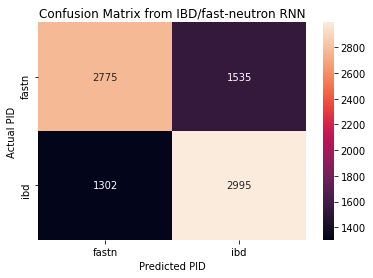

In [499]:
draw_confmat(classes=2)

In [502]:
(2775+2995)/(5770+1302+1535)

0.6703845706982688

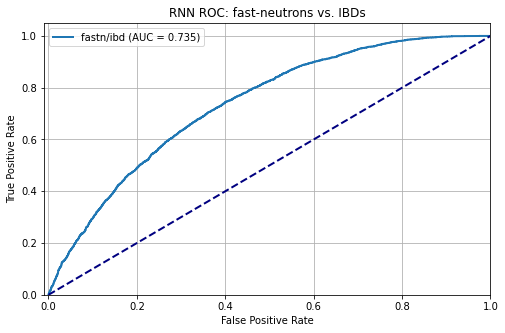

In [503]:
draw_roc(classes=2)

## Take RNN output and add to X1 (RF) data

In [510]:
def rnn_to_rf(classes=3, y_train=y_train, y_test=y_test):
    if classes==2: 
        yy_train, yy_test = y_train, y_test
    if classes>2:
        yy_train = np.argmax(y_train, axis=1)
        yy_test = np.argmax(y_test, axis=1)
        
    rnn_out_train = model.predict(X_train2)
    rnn_out_test = model.predict(X_test2)
    
    new_train = np.hstack((X_train1, rnn_out_train))
    new_test = np.hstack((X_test1, rnn_out_test))
    
    return new_train, new_test, yy_train, yy_test

In [520]:
classes=2
if classes==2: newdims = ['rnn_out']
elif classes==3: newdims = ['rnn_out_fn', 'rnn_out_ibd0', 'rnn_out_ibd1']

dims_add = dimensions.copy()
for i in newdims:
    dims_add.append(i)

In [511]:
new_train, new_test, yy_train, yy_test = rnn_to_rf(classes=2)

In [512]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(
    n_estimators=200, 
    max_depth=15, 
#     min_samples_leaf=2,
    bootstrap=True,
)
#Train the model using the training sets
clf.fit(new_train,yy_train)

RandomForestClassifier(max_depth=15, n_estimators=200)

In [513]:
y_train_pred = clf.predict(new_train)
y_test_pred=clf.predict(new_test)

In [514]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(yy_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(yy_test, y_test_pred)*100))

Train Accuracy: 95.15%
Test Accuracy: 84.36%


In [522]:
feature_imp = pd.Series(clf.feature_importances_,index=dims_add).sort_values(ascending=False)

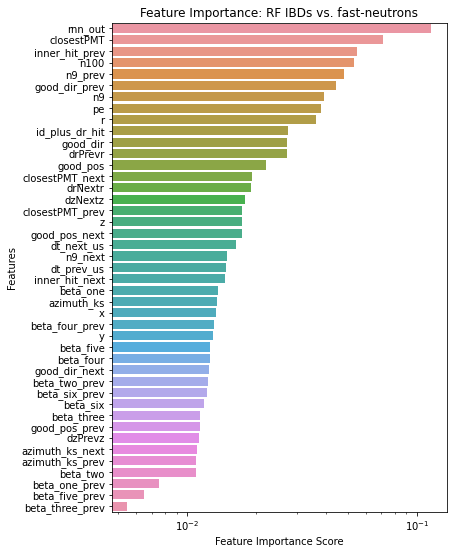

In [544]:
# Creating a bar plot
plt.figure(figsize=(6, 9))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF IBDs vs. fast-neutrons")
# plt.legend()
plt.show()

In [524]:
scores = clf.predict_proba(new_test)

In [530]:
if scores.shape[1]>1:
    y_pred_2 = np.argmax(scores, axis=1)
    try: y_test_2 = np.argmax(y_test, axis=1)
    except: y_test_2=y_test
else:
    y_pred_2, y_test_2 = np.round(scores), y_test

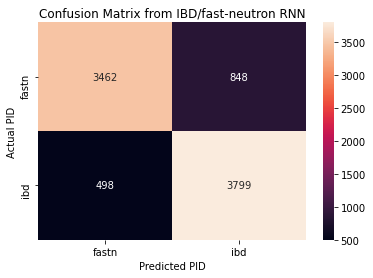

In [531]:
draw_confmat(classes=2, y_test_2=y_test_2, y_pred_2=y_pred_2)

In [533]:
ntot = np.sum(confmat)
nwrong = np.sum(confmat[1:,0]+confmat[0,1:])
1-nwrong/ntot

0.6423841059602649

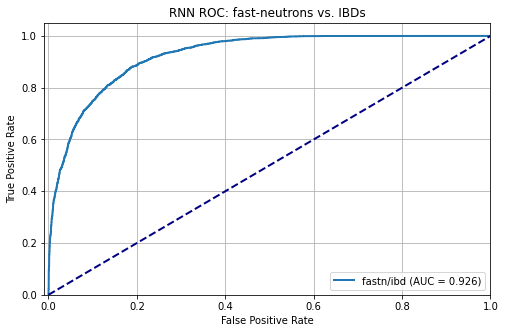

In [542]:
draw_roc(2, y_test_2, scores)

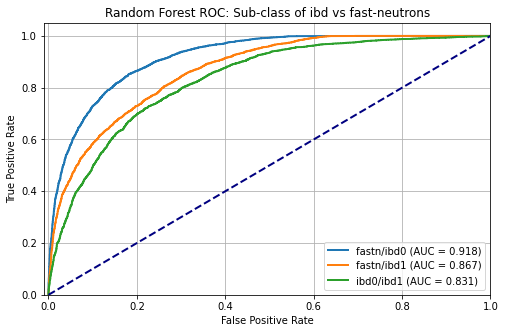

In [447]:
cat1 = [0, 0, 1]
cat2 = [1, 2, 2]
labels = ['fastn/ibd0', 'fastn/ibd1', 'ibd0/ibd1', 
#           'fastn1/ibd0', 'fastn1/ibd1', 
#           'ibd0/ibd1', 
         ]
plt.figure(figsize=(8,5))
for i, j, label in zip(cat1, cat2, 
                        labels,
                         ):
    mask = [any(t) for t in zip(yy_test==i, yy_test==j)]
    prob = scores[:, j][mask]
    
    guesses = yy_test[mask]
    guesses = guesses - np.min(guesses)
    guesses = guesses/np.max(guesses)

    fpr, tpr, thresholds = roc_curve(guesses, prob)
        
    auc = roc_auc_score(yy_test[mask], prob)
    plt.plot(fpr, tpr, 
         label='%s (AUC = %0.3f)'%(label, auc), 
#          color='darkorange', 
         lw=2, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC: Sub-class of ibd vs fast-neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.legend()
plt.grid()
plt.show()